In [1]:
import numpy as np
import torch 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from gmm import GMM
import data
import utils

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
def plot_logp_std(logps, dataset):
    data = []
    
    for logp, algorithm in logps:
        data.extend([(epoch, algorithm, np.mean(value), np.std(value)) for epoch, value in enumerate(logp)])

    df = pd.DataFrame(data, columns=['Epoch', 'Algorithm', 'Mean NLL', 'Std NLL'])

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 8))

    palette = sns.color_palette("deep", n_colors=len(logps))

    sns.lineplot(data=df, x='Epoch', y='Mean NLL', hue='Algorithm', style='Algorithm', 
                 markers=['s', 'd', 'o', '^'], markersize=8, markevery=2, 
                 dashes=False, linewidth=3, alpha=0.7, palette=palette)

    for algorithm in df['Algorithm'].unique():
        subset = df[df['Algorithm'] == algorithm]
        plt.fill_between(subset['Epoch'], subset['Mean NLL'] - subset['Std NLL'], subset['Mean NLL'] + subset['Std NLL'], alpha=0.3)

    plt.xlabel('Epochs', fontsize=20, fontweight='bold', labelpad=12)
    plt.ylabel('NLL', fontsize=20, fontweight='bold', labelpad=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    plt.tight_layout()

    if not os.path.exists(f'results/{dataset}/'): os.makedirs(f'results/{dataset}/')
    plt.savefig(f"results/{dataset}/logp_random_runs.png", format='png', dpi=300, bbox_inches='tight')

In [43]:
dataset = 'halfmoons'
algorithms = ['EM', 'GD', 'SM', 'SSM']

random_init = True
# ----------------------------- parameters -------------------------------
num_samples = 10000

K = 10                      # number of components 
lr = 0.01                   # learning rate
epochs = 200                # number of training epochs

n_slices = 1                # how many random vectors for sliced score matching

seed = 42
# np.random.seed(seed) 

n_runs = 10     

# -------------------------------- training ------------------------------
x = data.get_2d(dataset, num_samples * 2, seed)
np.random.shuffle(x)

kmeans = KMeans(K, random_state=seed)
kmeans.fit(x)
centers = kmeans.cluster_centers_

x_test = torch.tensor(x[:num_samples], dtype=torch.float32).to(device)
x = torch.tensor(x[num_samples:], dtype=torch.float32).to(device)

logps = np.zeros((len(algorithms), epochs+1, n_runs))

for run in range(n_runs):
    if random_init:
        random_indices = np.random.choice(x.shape[0], K, replace=False)
        centers = x[random_indices].detach().cpu().numpy()

    for idx, a in enumerate(algorithms):

        model = GMM(device, K, centers, random_init).to(device)

        train_logps = utils.train(model, x, a, lr, epochs, n_slices)
        logps[idx, :, run] = train_logps

        test_logp = model.log_likelihood(x_test)
        print(f'[{a:{3}}] Test Log-Likelihood (Run {run + 1}) = {test_logp:.4f}')


logps = [(logps[idx], algorithms[idx], ) for idx in range(len(algorithms))]

[EM ] Test Log-Likelihood (Run 1) = -1.0496
[GD ] Test Log-Likelihood (Run 1) = -1.0693
[SM ] Test Log-Likelihood (Run 1) = -1.0665
[SSM] Test Log-Likelihood (Run 1) = -1.0784
[EM ] Test Log-Likelihood (Run 2) = -1.0184
[GD ] Test Log-Likelihood (Run 2) = -1.0541
[SM ] Test Log-Likelihood (Run 2) = -1.0484
[SSM] Test Log-Likelihood (Run 2) = -1.0324
[EM ] Test Log-Likelihood (Run 3) = -1.1125
[GD ] Test Log-Likelihood (Run 3) = -1.0269
[SM ] Test Log-Likelihood (Run 3) = -1.0523
[SSM] Test Log-Likelihood (Run 3) = -1.0652
[EM ] Test Log-Likelihood (Run 4) = -1.0505
[GD ] Test Log-Likelihood (Run 4) = -1.0392
[SM ] Test Log-Likelihood (Run 4) = -1.0830
[SSM] Test Log-Likelihood (Run 4) = -1.0911
[EM ] Test Log-Likelihood (Run 5) = -1.0483
[GD ] Test Log-Likelihood (Run 5) = -1.0667
[SM ] Test Log-Likelihood (Run 5) = -1.0811
[SSM] Test Log-Likelihood (Run 5) = -1.0626
[EM ] Test Log-Likelihood (Run 6) = -1.0217
[GD ] Test Log-Likelihood (Run 6) = -1.0322
[SM ] Test Log-Likelihood (Run 6

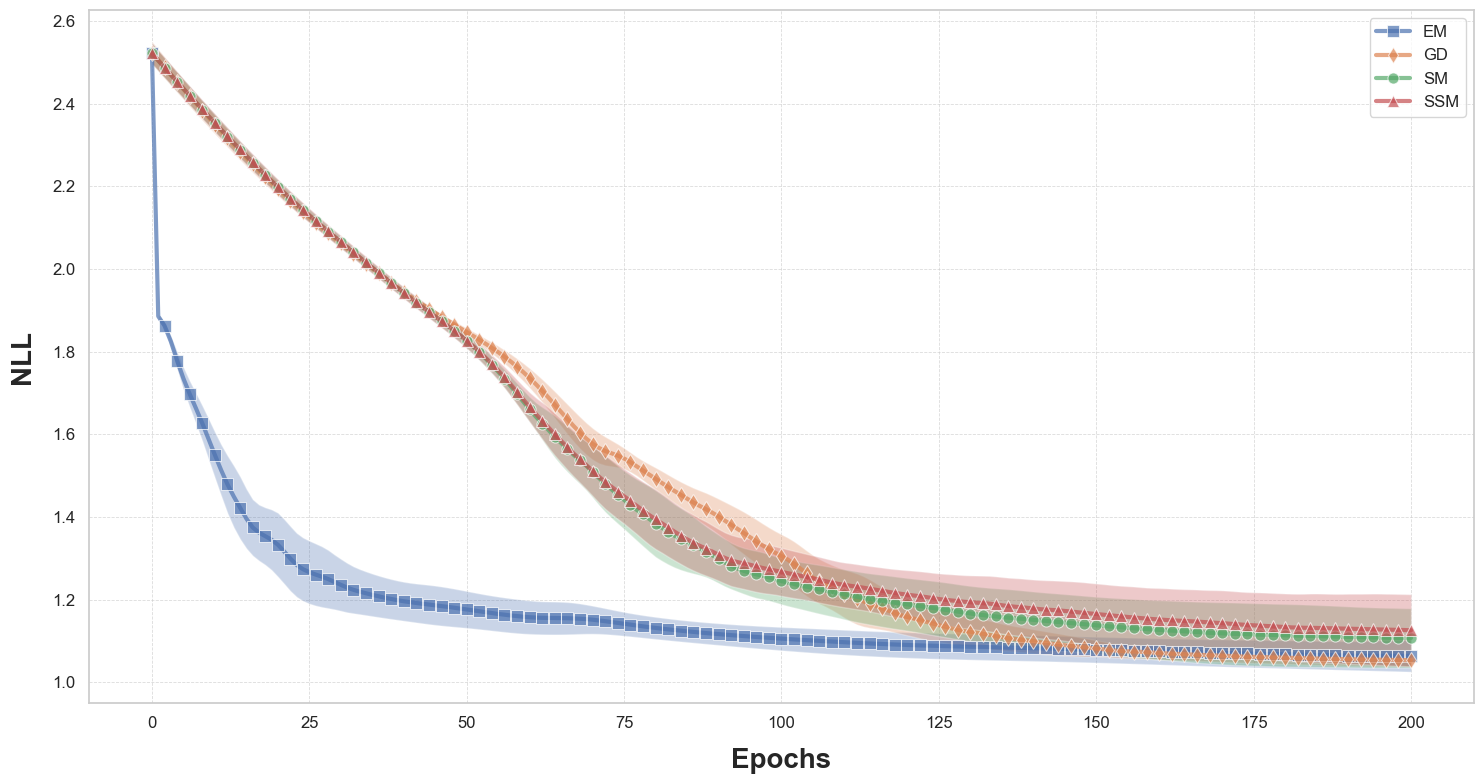

In [49]:
plot_logp_std(logps, dataset)